# Описание проекта

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


### Описание данных
Технологический процесс
 - Rougher feed — исходное сырье
 - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  - Xanthate **— ксантогенат (промотер, или активатор флотации);
  - Sulphate — сульфат (на данном производстве сульфид натрия);
  - Depressant — депрессант (силикат натрия).
 - Rougher process (англ. «грубый процесс») — флотация
 - Rougher tails — отвальные хвосты
 - Float banks — флотационная установка
 - Cleaner process — очистка
 - Rougher Au — черновой концентрат золота
 - Final Au — финальный концентрат золота
 
### Параметры этапов
 - air amount — объём воздуха
 - fluid levels — уровень жидкости
 - feed size — размер гранул сырья
 - feed rate — скорость подачи

#### Наименование признаков должно быть такое:<br>
   [этап].[тип_параметра].[название_параметра]<br>
Пример:  rougher.input.feed_ag <br>
#### Возможные значения для блока [этап]:
 - rougher — флотация
 - primary_cleaner — первичная очистка
 - secondary_cleaner — вторичная очистка
 - final — финальные характеристики
 
#### Возможные значения для блока [тип_параметра]:
 - input — параметры сырья
 - output — параметры продукта
 - state — параметры, характеризующие текущее состояние этапа
 - calculation — расчётные характеристики

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import seaborn as sns
import warnings
import time


from sklearn.metrics import make_scorer, mean_absolute_error, accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
warnings.filterwarnings("ignore")

# 1. Подготовка данных.

In [3]:
data_train = pd.read_csv('gold_recovery_train.csv')


In [4]:
def recovery(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    try:
        return 100 * ((C*(F-T)) / (F*(C-T))) 
    except:
        pass

$$
    recovery= \frac{C*(F-T)}{F*(C-T)} * 100\% 
$$
Где:
 - C — доля золота в концентрате после флотации/очистки;
 - F — доля золота в сырье/концентрате до флотации/очистки;
 - T — доля золота в отвальных хвостах после флотации/очистки.

In [5]:

COPY_train = data_train.copy()

COPY_train['recovery'] = COPY_train.apply(recovery, axis=1)

COPY_train.dropna(subset=['recovery', 'rougher.output.recovery'], inplace=True)

rougher_out_rec = COPY_train['rougher.output.recovery']
recovery = COPY_train['recovery']

MAE = mean_absolute_error(rougher_out_rec, recovery)
print('MAE между расчетами и значение признака:', MAE)


MAE между расчетами и значение признака: 9.444891926100695e-15


Значение близко к нулю, значит значение расчитано правильно.

In [6]:
data_test = pd.read_csv('gold_recovery_test.csv')


In [7]:
columns_train = data_train.columns
columns_test = data_test.columns

miss_columns = []
for column in columns_train:
    if column not in columns_test:
        miss_columns.append(column)
print('Отсутвующие колонки в тестновой выборке:')
miss_columns

Отсутвующие колонки в тестновой выборке:


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Отсутвующие параметры относятся к финальным и выходным данным.(final, output). потому что замеряются и/или рассчитываются значительно позже.

In [8]:
data_full = pd.read_csv('gold_recovery_full.csv')
data_full = data_full.dropna().reset_index(drop=True)

In [9]:
data_train = data_train.dropna().reset_index(drop=True)
data_test = data_test.dropna().reset_index(drop=True)


Импортируем полные данные.

# 2. Анализ данных

In [10]:
def borders(column):

                                   
    # для графиков                               
    data = data_full[column]                               
    first_border = np.percentile(data, q=15)
    
    data_to_plot = data[(first_border < data)]
    data_full[column] = data_to_plot
    
    return data_to_plot
    

Функция для нохождения границ выбросов.

In [11]:
metals = ['concentrate_au', 'concentrate_ag', 'concentrate_pb']
metals_tail = ['tail_au', 'tail_ag', 'tail_pb']

steps = ['rougher', 'primary_cleaner', 'secondary_cleaner']

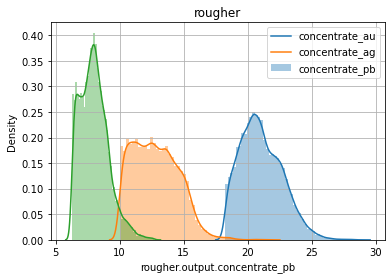

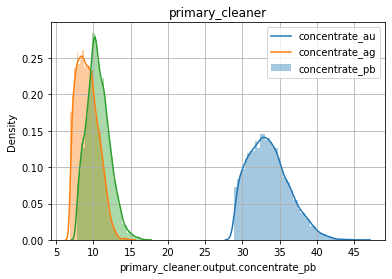

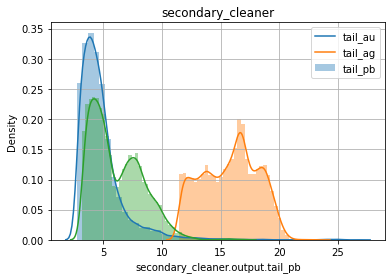

In [12]:
for step in steps:
    if step != 'secondary_cleaner':
        plt.xlabel('Концентрация')
        plt.grid()
        plt.title(step)
        
        for metal in metals:
            plt.legend(metals)
            
            column = f'{step}.output.{metal}' 
            data_to_plot = borders(column)

            sns.distplot(data_to_plot, label = metal)
        plt.show()
        
        
    else:
        plt.xlabel('Концентрация')
        plt.grid()
        plt.title(step)
            
        for metal in metals_tail:
            plt.legend(metals_tail)
            column = f'{step}.output.{metal}'
            data_to_plot = borders(column)
            
            
            sns.distplot(data_to_plot, label = metals)
        plt.show()

Концентрация золота растет с каждым этапом очистки

## Размер гранул.

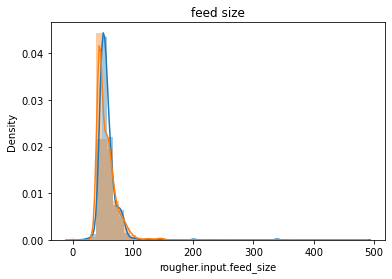

In [13]:
plt.title('feed size')

sns.distplot(data_train['rougher.input.feed_size'])
sns.distplot(data_test['rougher.input.feed_size'])
plt.show()

В тестовых и обучающих даныых распределенеие размер гранул кардинально не различаются. 

### Суммарная концентрация всех веществ.

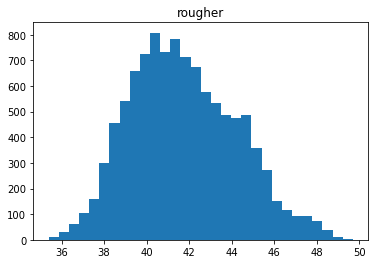

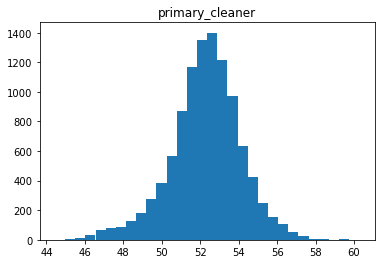

In [14]:

for step in steps[:-1]:
    plt.title(step)
    data_to_plot = data_full[f'{step}.output.concentrate_au'] + data_full[f'{step}.output.concentrate_ag']+ data_full[f'{step}.output.concentrate_pb']
    plt.hist(data_to_plot, bins=30)
    plt.show()


Суммарное распределения выходной концентрации - нормальное.

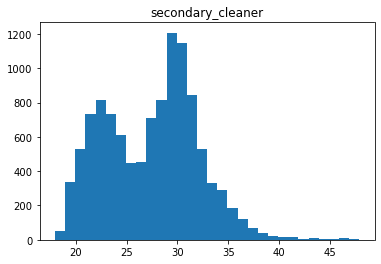

In [15]:
plt.title('secondary_cleaner')
data_to_plot = data_full[f'secondary_cleaner.output.tail_au'] + data_full[f'secondary_cleaner.output.tail_ag'] + data_full[f'secondary_cleaner.output.tail_pb']

plt.hist(data_to_plot, bins=30)
plt.show()

In [16]:
data_full = data_full.dropna().reset_index(drop=True)

In [17]:
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')

# 3. Модель

## sMape и finalsMAPE

In [18]:
def sMAPE(target, predict):
    len_target = target.shape[0]
    return  ((abs(target-predict)/((abs(target)+abs(predict))/2)) * 100).mean()
    
def fin_sMAPE(smape_rougher, smape_final):
    return 0.25*smape_rougher + 0.75*smape_final

$$
   sMAPE =  \frac{1}{n} *\sum_{i=1}^{N} \frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|) / 2} *100\%
$$

$$
    final\  sMAPE =  25\%* sMAPE(rougher) + 75\%*sMAPE(final)
$$ 


### Востановление таргета для теста

In [19]:
targets_to_test = data_full[['date', 'rougher.output.recovery', 'final.output.recovery', ]]
data_test = data_test.merge(targets_to_test, on='date')
# добавил  таргет в тестовую выборку.

### Борьба с мультиколлинеарностью

In [20]:
data_train = data_train[data_test.columns] # убрал отсуттвующие колонкки. 

data_corr = pd.DataFrame((data_train.corr() >= 0.9).sum())
data_train = data_train.drop(columns=data_corr[data_corr[0]>1].index)
data_test = data_test[data_train.columns] # убрал отсуттвующие колонкки. 


# Обучение моделей.

In [21]:
sMAPE_score = make_scorer(sMAPE, greater_is_better=False) # задаем метрику оценки для GridSearchCV

def make_features(features, target):
    features = features
    target =  target

    features_train, features_test, target_train, target_test = train_test_split(
                                        features, target, test_size=0.25, random_state=666)
    
    
    
    return features_train, features_test, target_train, target_test


def learn_model(models, features_train, features_test, target_train, target_test, title=''):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        
        metrics = {'MAE': mean_absolute_error,
                   'sMAPE' : sMAPE,
                  }
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])


        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        
        print(results)
        print()
    
    def fit_model():
        

        plot_data = {}
        learned_model = {}
        
        for model in models.keys():
            print(f'__________{model}__________')
            model_learn = models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            
            grid = GridSearchCV(model_learn, cv=5, param_grid=params, n_jobs=-1, scoring=sMAPE_score)
            grid.fit(features_train, target_train)
            end_time = time.time()
            fit_time = end_time - start_time
            
            plot_data[model] = fit_time # время обучения модели
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            
            
            
            train_predict = grid.predict(features_train)
            test_predict = grid.predict(features_test)
            
            predicted = predict(model, train_predict, target_train, test_predict, target_test)
            
            
        sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), saturation=1)    
        plt.xlabel('Модели')
        plt.ylabel('Время')
        plt.title(f'Время обучения {title}')
        plt.show()
        
        return learned_model
        
        
    result_model = fit_model()    
    
    
        
    return result_model
            


Функция learn_model обучает модели и показывает метрики и время обучения.

### Разбиение данныз для теста

In [22]:
target_test_1, target_test_2 = data_test['rougher.output.recovery'], data_test['final.output.recovery']
features_test = data_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

### Разбивка дынных для обучения.

In [23]:
target_train_1, target_train_2 = data_train['rougher.output.recovery'], data_train['final.output.recovery']
features_train = data_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

## Обучение модели для признака rougher.

In [24]:
models = {'Linear' : [LinearRegression(n_jobs=-1), {}],
          
          'Forest' : [RandomForestRegressor(n_jobs=-1), {'max_depth':range(1, 10, 4),
                                                         'min_samples_leaf':range(1, 7, 3),
                                                         'min_samples_split':range (2, 10,4), 
                                                         'n_estimators':range(10, 110, 10)}],
          'LightGBM' : [LGBMRegressor(n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                   'max_depth':range(1, 15, 1),
                                                   'n_estimators':range(1, 101, 25)}],
          
          'CatBoost' : [CatBoostRegressor(silent=True, iterations=40), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                          'depth':range(1, 15, 1)}]
         }

Обозначаем модели для обучения и их параметры.

__________Linear__________
          train      test
MAE    5.737788  4.777481
sMAPE  9.022603  5.629968

__________Forest__________
          train      test
MAE    4.535581  5.244731
sMAPE  8.319620  6.225207

__________LightGBM__________
          train      test
MAE    5.865445  4.376453
sMAPE  9.101820  5.131500

__________CatBoost__________
          train      test
MAE    5.692942  4.787043
sMAPE  8.946496  5.637356



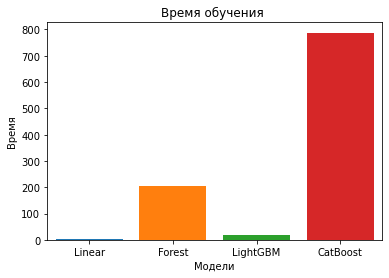

Wall time: 16min 51s


In [25]:
%%time
models_rougher = learn_model(models, features_train, features_test, target_train_1, target_test_1)

In [26]:
best_predict_rougher = models_rougher['LightGBM'][0].predict(features_test)
best_sMAPE_rougher = sMAPE(target_test_1, best_predict_rougher)
best_sMAPE_rougher

5.13149961823596

## Обучение модели для признака final.

In [27]:
models = {'Linear' : [LinearRegression(n_jobs=-1), {}],
          
          'Forest' : [RandomForestRegressor(n_jobs=-1), {'max_depth':range(1, 10, 4),
                                                         'min_samples_leaf':range(1, 7, 3),
                                                         'min_samples_split':range (2, 10,4), 
                                                         'n_estimators':range(10, 110, 10)}],
          'LightGBM' : [LGBMRegressor(n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                   'max_depth':range(1, 15, 1),
                                                   'n_estimators':range(1, 101, 25)}],
          
          'CatBoost' : [CatBoostRegressor(silent=True, iterations=40), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                          'depth':range(1, 15, 1)}]
         }

__________Linear__________
          train      test
MAE    4.832542  4.785919
sMAPE  7.727462  7.281035

__________Forest__________
          train      test
MAE    5.310134  5.089298
sMAPE  8.444057  7.761892

__________LightGBM__________
          train      test
MAE    4.956497  4.428854
sMAPE  7.905166  6.803051

__________CatBoost__________
          train      test
MAE    4.846436  4.407565
sMAPE  7.745474  6.771506



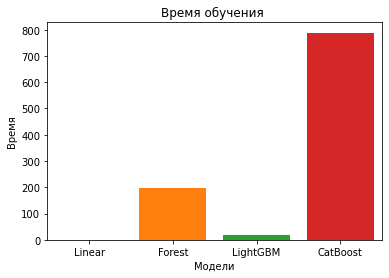

Wall time: 16min 41s


In [28]:
%%time
models_final = learn_model(models, features_train, features_test, target_train_2, target_test_2)

In [31]:
best_predict_final = models_final['LightGBM'][0].predict(features_test)
best_sMAPE_final = sMAPE(target_test_2, best_predict_final)
best_sMAPE_final

6.80305118393658

# Final sMAPE

In [32]:
fin_sMAPE(best_sMAPE_rougher, best_sMAPE_final)

6.385163292511424

Финальное sMAPE получилось не самым лучшим, но это обусловлено данными которые нам дали.

### Вывод 
Выбираем модели градиентного бустинга LightGBM за их скорость и качество предсказаний.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке